# PDBe API Training

### PDBe Ligand Interactions for a given protein

This tutorial will guide you through searching PDBe programmatically.


First we will import the code which will do the work
Run the cell below - by pressing the green play button.

In [7]:
import pandas as pd
import numpy as np
import requests
from pprint import pprint
import matplotlib.pyplot as plt
from IPython.display import SVG, display
import sys
sys.path.insert(0,'..')
from python_modules.api_modules import explode_dataset, get_ligand_site_data, get_similar_ligand_data

Now we are ready to find all the ligands and its interaction details bound to a given protein.

We will get ligands for a  SARS-CoV-2 Spike glycoprotein whose UniProt accession is P0DTC2 

In [8]:
uniprot_accession = 'P0DTC2'

uniprot_accession

'P0DTC2'

Get compounds which interact with the UniProt

In [9]:
ligand_data = get_ligand_site_data(uniprot_accession=uniprot_accession)

https://www.ebi.ac.uk/pdbe/graph-api/uniprot/ligand_sites/P0DTC2


In [10]:
#pprint(ligand_data)

In [6]:
df2 = explode_dataset(result=ligand_data, column_to_explode='interactingPDBEntries')

Some post processing is required to separating interactingPDBEntries into separate columns

In [23]:
print(df2.head())

   startIndex  endIndex startCode endCode indexType  \
0         660       660       TYR     TYR   UNIPROT   
1         673       673       SER     SER   UNIPROT   
2         675       675       GLN     GLN   UNIPROT   
3         693       693       ILE     ILE   UNIPROT   
4         695       695       TYR     TYR   UNIPROT   

                               interactingPDBEntries allPDBEntries  \
0  {'pdbId': '7qur', 'entityId': 1, 'chainIds': 'B'}        [7qur]   
1  {'pdbId': '7qur', 'entityId': 1, 'chainIds': 'B'}        [7qur]   
2  {'pdbId': '7qur', 'entityId': 1, 'chainIds': 'B'}        [7qur]   
3  {'pdbId': '7qur', 'entityId': 1, 'chainIds': 'B'}        [7qur]   
4  {'pdbId': '7qur', 'entityId': 1, 'chainIds': 'B'}        [7qur]   

  ligand_accession                   ligand_name  ligand_num_atoms  \
0              GE9  2,3,5-tris(iodanyl)benzamide                12   
1              GE9  2,3,5-tris(iodanyl)benzamide                12   
2              GE9  2,3,5-tris(iodanyl

In [24]:
data = pd.json_normalize(df2['interactingPDBEntries'])
df3 = df2.join(data).drop(columns='interactingPDBEntries')


startIndex and endIndex are the UniProt residue number, so we'll make a new column called residue_number
and copy the startIndex there.
We are also going to "count" the number of results - so we'll make a dummy count column to store it in

In [25]:
df3['residue_number'] = df3['startIndex']
df3['count'] = df3['pdbId']

Now we are ready to use the data.

In [26]:
df3.head()

,startIndex,endIndex,startCode,endCode,indexType,allPDBEntries,ligand_accession,ligand_name,ligand_num_atoms,uniprot_accession,interaction_ratio,pdbId,entityId,chainIds,residue_number,count
0,660,660,TYR,TYR,UNIPROT,[7qur],GE9,"2,3,5-tris(iodanyl)benzamide",12,P0DTC2,1.0,7qur,1,B,660,7qur
1,673,673,SER,SER,UNIPROT,[7qur],GE9,"2,3,5-tris(iodanyl)benzamide",12,P0DTC2,1.0,7qur,1,B,673,7qur
2,675,675,GLN,GLN,UNIPROT,[7qur],GE9,"2,3,5-tris(iodanyl)benzamide",12,P0DTC2,1.0,7qur,1,B,675,7qur
3,693,693,ILE,ILE,UNIPROT,[7qur],GE9,"2,3,5-tris(iodanyl)benzamide",12,P0DTC2,1.0,7qur,1,B,693,7qur
4,695,695,TYR,TYR,UNIPROT,[7qur],GE9,"2,3,5-tris(iodanyl)benzamide",12,P0DTC2,1.0,7qur,1,B,695,7qur


Ligands which interact with every entry have an interaction_ratio of 1.0.
So lets get them....

In [27]:
df4 = df3.groupby('ligand_accession')['interaction_ratio'].mean().reset_index()
ret = df4.query('interaction_ratio == 1.0')['ligand_accession'].values

In [28]:
ret

array(['BU2', 'CA', 'CD', 'GAL', 'GE9', 'IOD', 'K', 'NDG', 'POL', 'SCN',
       'SIA', 'STE', 'XYL'], dtype=object)

Lets see if we can filter ligands by which ligands interact with the residues which have the most interactions.

First lets see how many interactions we have per residue.

In [29]:
df4 = df3.groupby('residue_number')['count'].count().reset_index()

<AxesSubplot:xlabel='residue_number', ylabel='count'>

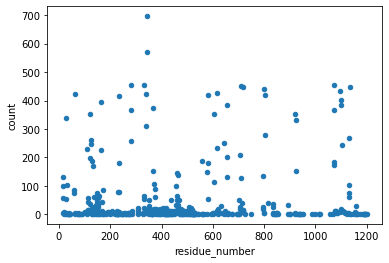

In [30]:
df4.plot.scatter(x='residue_number', y='count')

We can the determine the mean number of interactions

In [31]:
mean = df4.mean()
mean

residue_number    482.891949
count              47.940678
dtype: float64

We need to extract the mean value as a number from the above result

In [32]:
mean_value = float(mean.values[1])
mean_value

47.940677966101696

Then we can plot residues which have more interactions than the mean in red
and those which are equal to or below in blue.

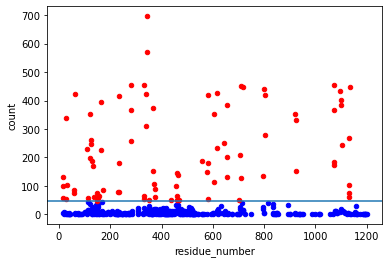

In [33]:
fig, ax = plt.subplots() # this makes one plot with an axis "ax" which we can add several plots to
df4.query('count <= {}'.format(mean_value)).plot.scatter(x='residue_number', y='count', color='blue', ax=ax)
df4.query('count > {}'.format(mean_value)).plot.scatter(x='residue_number', y='count', color='red', ax=ax)
ax.axhline(mean_value)
plt.show()
plt.close()


The actual residues are

In [34]:
all_data_over_mean = df4.query('count > {}'.format(mean_value))
all_data_over_mean


,residue_number,count
1,15,101
2,16,57
3,17,132
10,28,340
11,29,53
...,...,...
448,1130,269
449,1131,104
450,1132,62
451,1133,75


we only want the residue numbers for the next step

In [35]:
residue_numbers_over_mean = all_data_over_mean['residue_number']
residue_numbers_over_mean

1        15
2        16
3        17
10       28
11       29
       ... 
448    1130
449    1131
450    1132
451    1133
452    1134
Name: residue_number, Length: 90, dtype: int64

What ligands interact with these residues?

Now we want to get all ligand_accessions which interact with a residue in "residue_numbers_over_mean"

In [36]:
df5  = df3[df3['residue_number'].isin(residue_numbers_over_mean)]['ligand_accession']
df5

5        IMD
6        IMD
7        IMD
8        IMD
83       FUL
        ... 
22567    SO4
22568    SO4
22571    SO4
22572    SO4
22573    SO4
Name: ligand_accession, Length: 19999, dtype: object

The same ligand appears several times so we an "unique" the list to get our list of ligands
which have a number of interactions over the mean interaction count.

In [37]:
interesting_ligands = list(df5.unique())
interesting_ligands

['IMD',
 'FUL',
 'NDG',
 'BMA',
 'MAN',
 'FUC',
 'NAG',
 'PRO',
 'GOL',
 'CIT',
 'SCN',
 'POL',
 '1PE',
 'MPD',
 'PGE',
 'PO4',
 'CAC',
 'STE',
 'PG4',
 'DMS',
 'CA',
 'ELA',
 'EIC',
 'FMT',
 'PEG',
 'ACT',
 'CL',
 'EDO',
 'SO4']

It's worth seeing which ligands are not in our list

In [38]:
all_ligands = list(df3['ligand_accession'].unique())

missing_ligands = [x for x in all_ligands if x not in interesting_ligands]
missing_ligands

['GE9',
 'BLA',
 'GAL',
 'SIA',
 'VCG',
 'BR',
 'PG0',
 'IOD',
 'NO3',
 'BU2',
 'XYL',
 'K',
 'IPA',
 'TRS',
 'ZN',
 'CD',
 'NA']

Now we can display the interactions only for those ligands we have found

We will start with our Dataframe df3

In [39]:
df3.head()

,startIndex,endIndex,startCode,endCode,indexType,allPDBEntries,ligand_accession,ligand_name,ligand_num_atoms,uniprot_accession,interaction_ratio,pdbId,entityId,chainIds,residue_number,count
0,660,660,TYR,TYR,UNIPROT,[7qur],GE9,"2,3,5-tris(iodanyl)benzamide",12,P0DTC2,1.0,7qur,1,B,660,7qur
1,673,673,SER,SER,UNIPROT,[7qur],GE9,"2,3,5-tris(iodanyl)benzamide",12,P0DTC2,1.0,7qur,1,B,673,7qur
2,675,675,GLN,GLN,UNIPROT,[7qur],GE9,"2,3,5-tris(iodanyl)benzamide",12,P0DTC2,1.0,7qur,1,B,675,7qur
3,693,693,ILE,ILE,UNIPROT,[7qur],GE9,"2,3,5-tris(iodanyl)benzamide",12,P0DTC2,1.0,7qur,1,B,693,7qur
4,695,695,TYR,TYR,UNIPROT,[7qur],GE9,"2,3,5-tris(iodanyl)benzamide",12,P0DTC2,1.0,7qur,1,B,695,7qur


We will select only ligands which interact the most in a Dataframe df6

In [40]:
df6 = df3.groupby(['residue_number', 'ligand_accession'])['interaction_ratio'].mean().reset_index()

We are going to scale the interactions as we use this later

In [41]:
df6['interaction_ratio'] = df6['interaction_ratio'].apply(lambda x: x*2)
df6

,residue_number,ligand_accession,interaction_ratio
0,14,NAG,0.007828
1,14,PGE,1.000000
2,15,NAG,0.391473
3,16,NAG,0.217557
4,17,FUC,0.090909
...,...,...,...
1027,1194,NAG,0.007921
1028,1195,EDO,2.000000
1029,1195,ZN,0.142857
1030,1199,ZN,0.142857


Now we can plot the ligand interactions of those ligands which interact with the most interacting residues.

We will put each ligand on a row and scale the interactions by the percentage of PDB entries they are seen in.


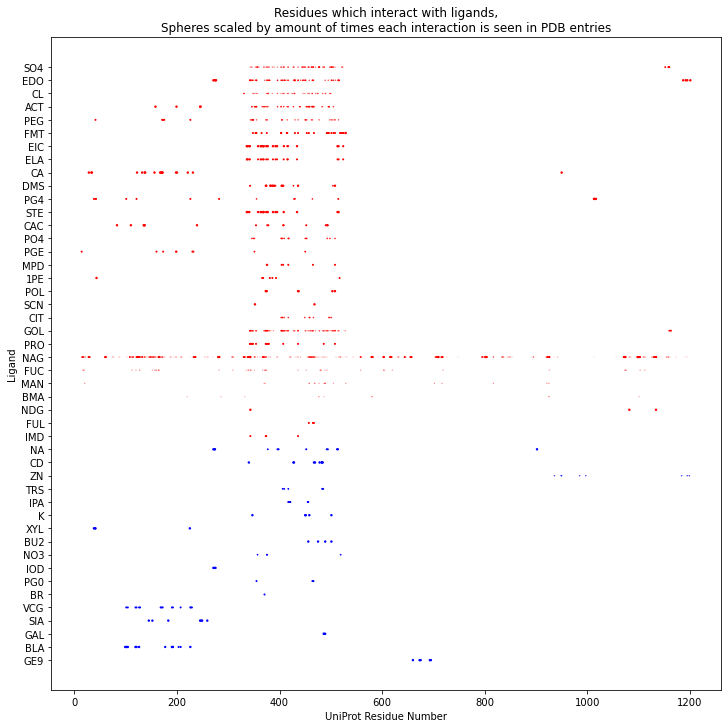

In [42]:
# prepare a figure
plt.rcParams['figure.figsize'] = [12, 12]
fig, ax = plt.subplots()

# plot the less interesting ligands in blue
for ligand in missing_ligands:
    data = df6[df6['ligand_accession'] == ligand]
    data.plot.scatter(x='residue_number', y='ligand_accession', ax=ax, s='interaction_ratio', c='blue')

# plot the interesting ligands in red
for ligand in interesting_ligands:
    data = df6[df6['ligand_accession'] == ligand]
    data.plot.scatter(x='residue_number', y='ligand_accession', ax=ax, s='interaction_ratio', c='red')


plt.ylabel('Ligand')
plt.xlabel('UniProt Residue Number')
plt.title('Residues which interact with ligands,\nSpheres scaled by amount of times each interaction is seen in PDB entries')
plt.show()
plt.close()

It would be interesting to see if the ligands binding to same residues are similar to each other. Let's take any ligand from above interesting ligand dataset and find all the other ligands which are similar to it. 

In the example below, we have taken "alpha-L-fucopyranose" (HET CODE- FUC) and find all the ligands similar to it using "get_similar_ligand_data" function. This function takes ligand name and similarity cutoff (0-1) as arguments. Here we have used similarity cutoff of 0.7 and found all the ligands which are 70 % or more similar to FUC. 

In [54]:
ligand_exp = "FUC"
similarity_cutoff = 0.7
#finding similar ligands to ligand_exp 
similar_ligands = get_similar_ligand_data(ligand_exp, similarity_cutoff)
sdf=pd.DataFrame(similar_ligands.items(),columns = ['similar_ligand','similarity_score'])
print(sdf)
#find common ligands from similar_ligands and interesting_ligands
common_ligands = [item for item in similar_ligands if item in interesting_ligands]
print(common_ligands)

https://www.ebi.ac.uk/pdbe/graph-api/compound/similarity/FUC
    similar_ligand  similarity_score
0              TFU             0.769
1              TGA             0.733
2              TGK             0.833
3              YIO             0.769
4              TGY             0.833
..             ...               ...
177            EMZ             0.846
178            EVA             0.714
179            EXO             0.833
180            FDK             0.769
181            FSW             0.714

[182 rows x 2 columns]
['MAN', 'BMA']


Now, you can compare if FUC and common_ligands bind to same residues or not and check if similar ligands tend to bind to similar sites.